In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

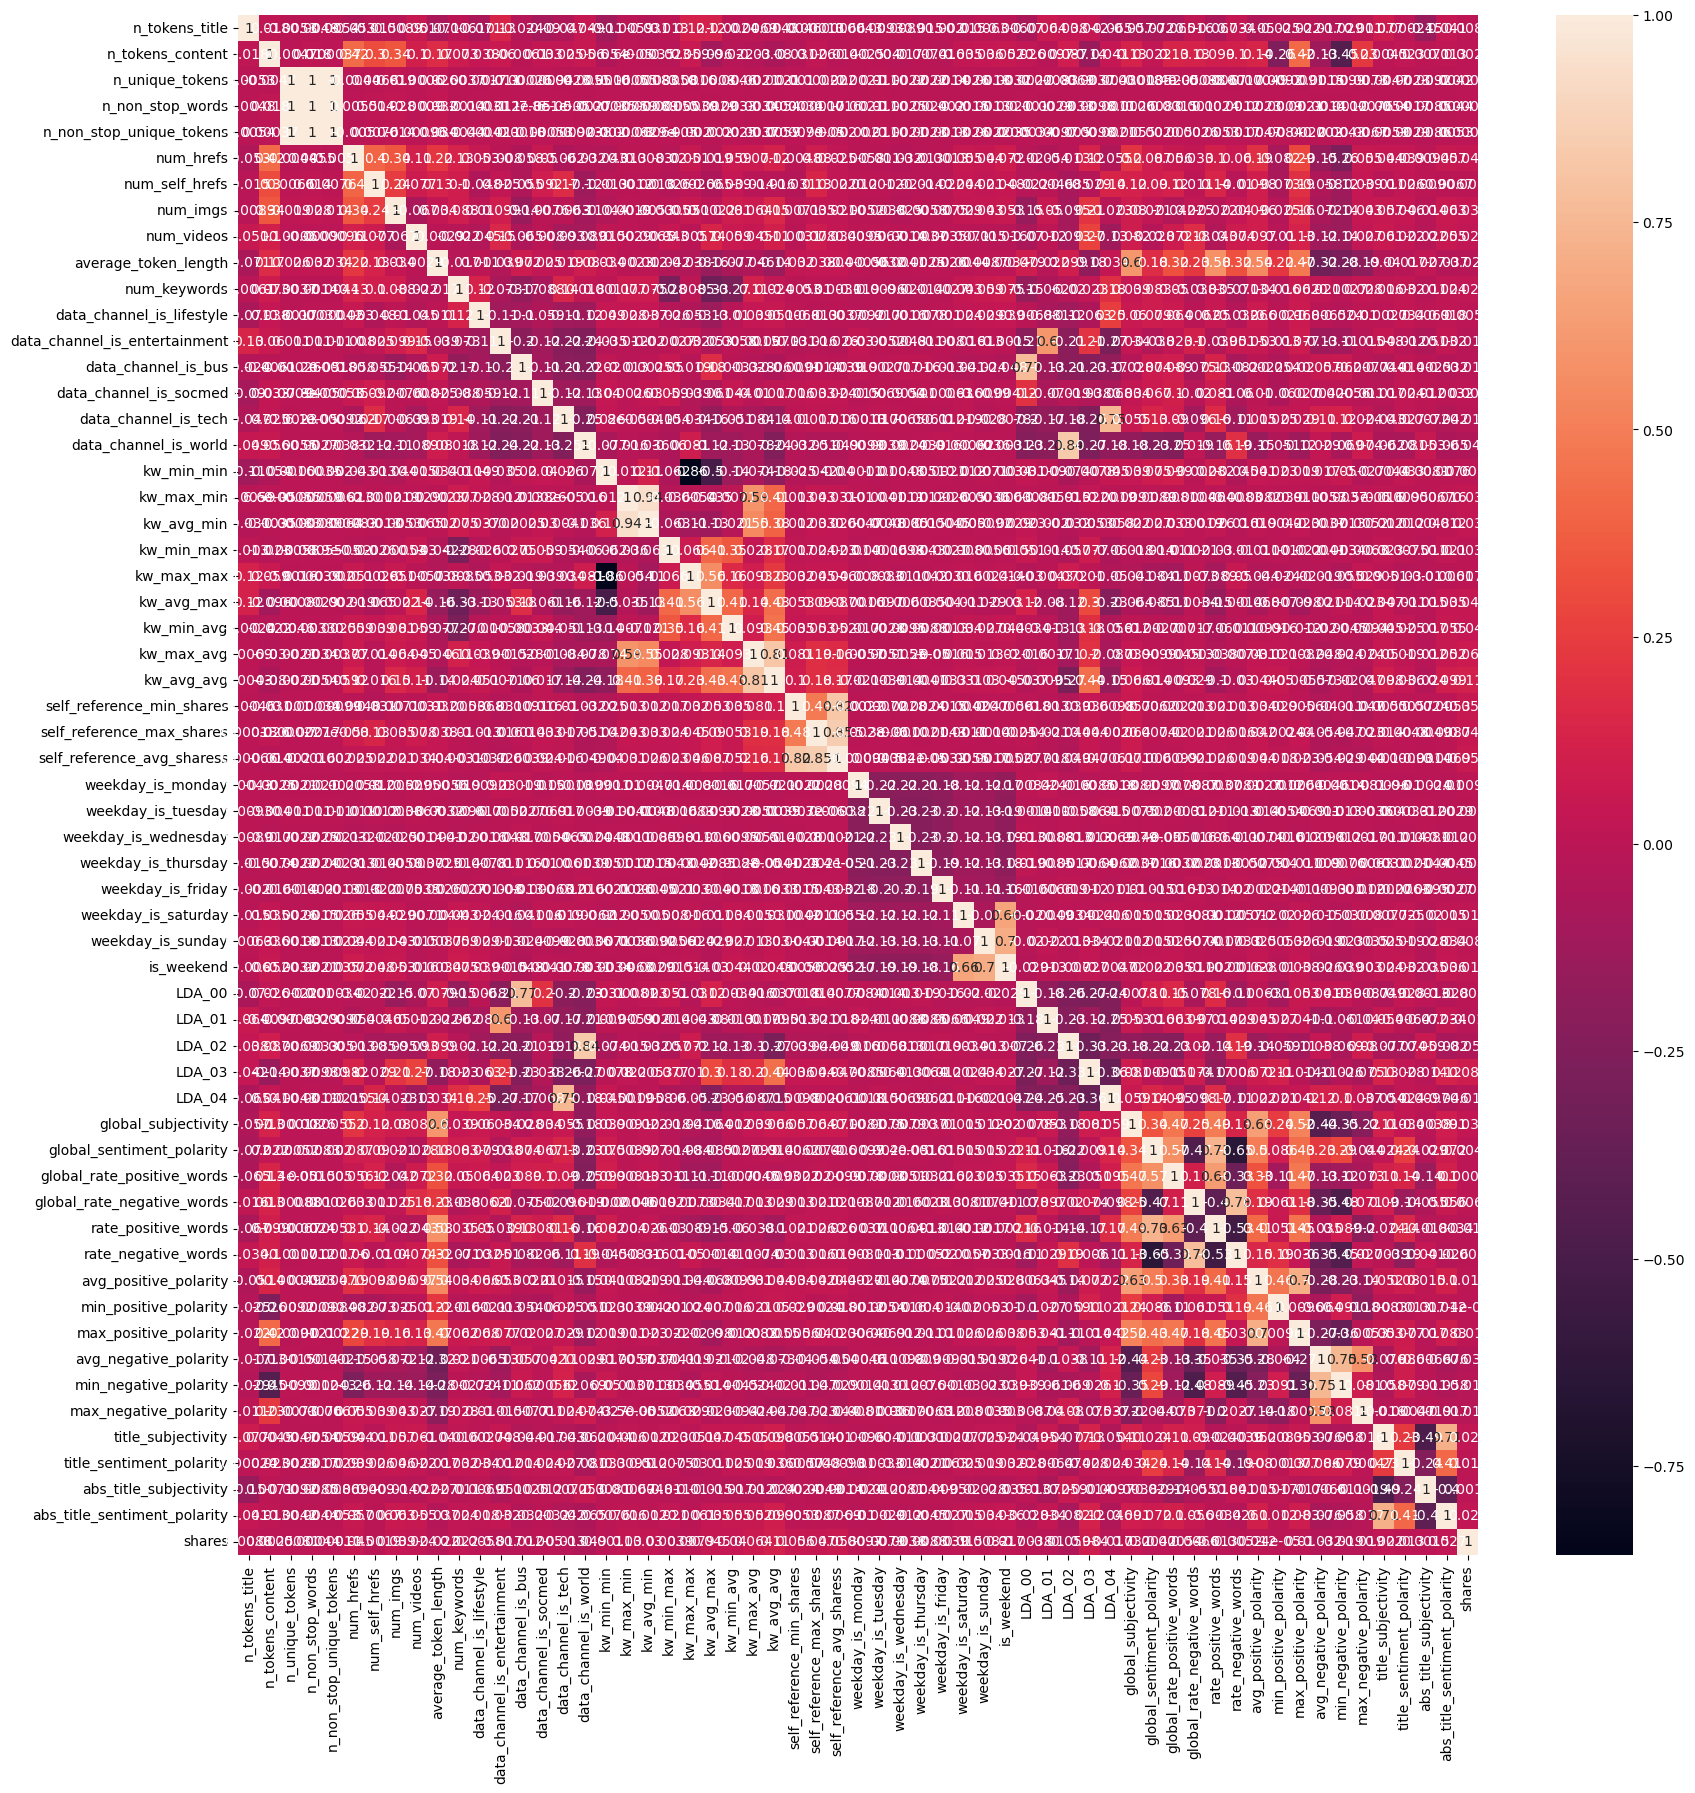

(39644, 40)


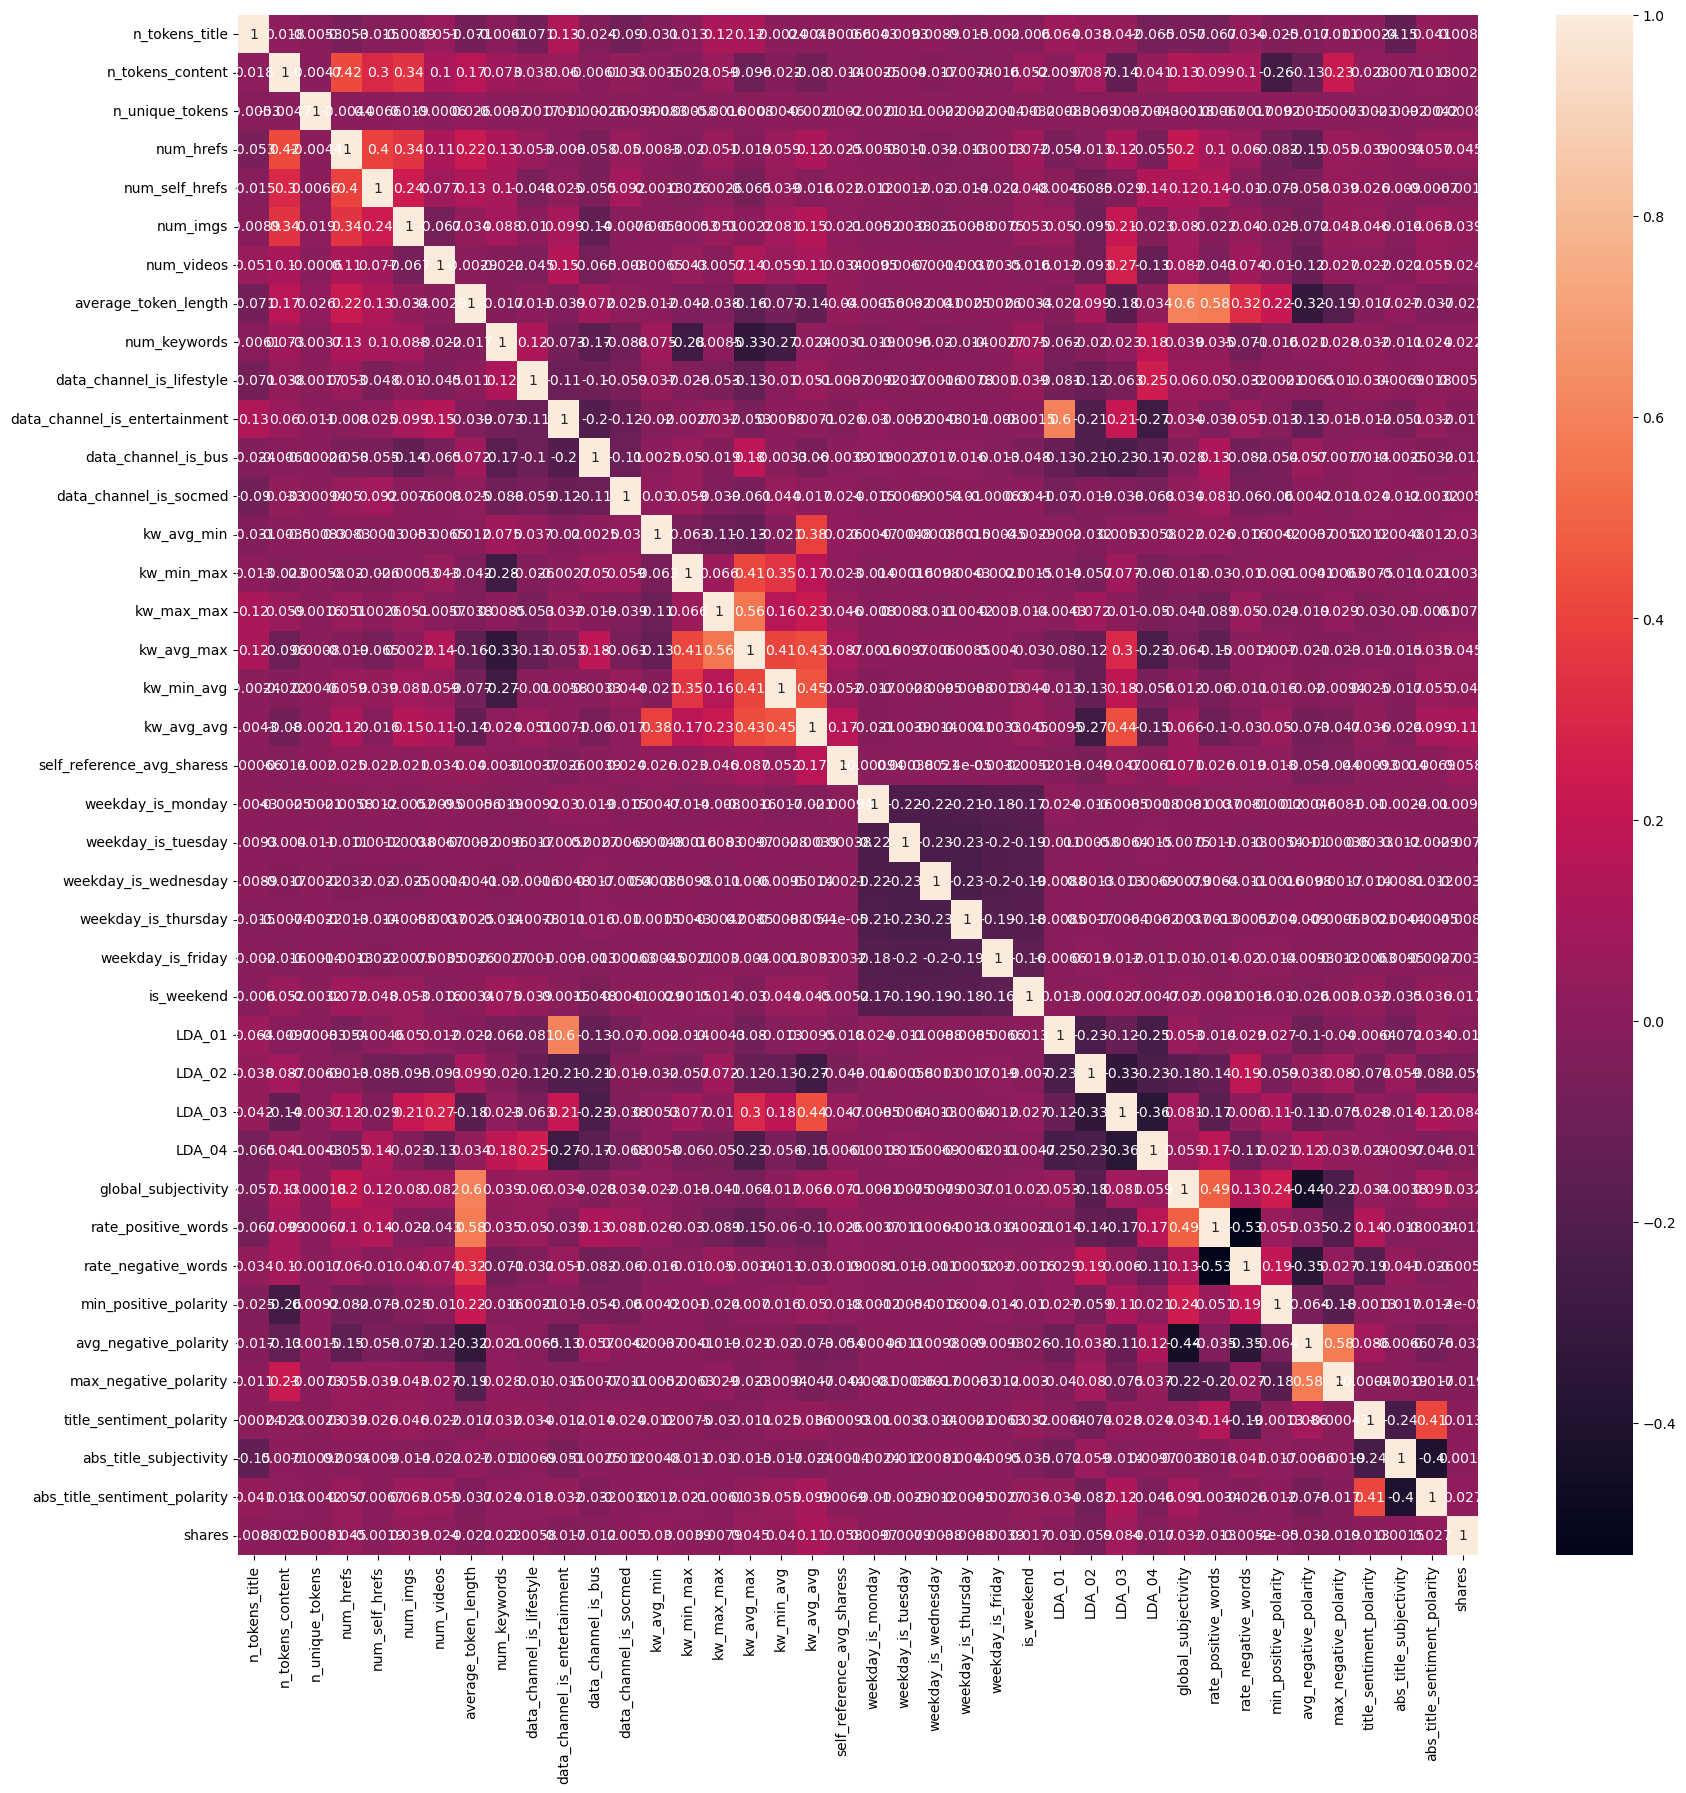

In [16]:
news_df_raw = pd.read_csv('data/OnlineNewsPopularity.csv')
news_df_raw.columns = news_df_raw.columns.str.strip()
news_df_regression = news_df_raw
news_df_regression = news_df_regression.drop(columns = ['url', 'timedelta']) # Non-predictive

threshold = 0.6
high_corr_features = {}
corrMat = news_df_regression.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrMat, annot=True)
plt.savefig('correlation_regression_before.png')
plt.show()

# Print highly correlated features
# for col in corrMat.columns:
#     highly_correlated = corrMat.index[(np.abs(corrMat[col]) > threshold) & (corrMat.index != col)].tolist()
#     if highly_correlated:
#         high_corr_features[col] = highly_correlated

# # Print feature correlation with 'shares'
# for col in corrMat.columns:
#     if col != 'shares':
#         corr_value = corrMat.loc[col, 'shares']
#         # if np.abs(corr_value) > threshold:
#         print(f"{col} and shares: {corr_value:.5f}")

# Feaure extraction
excluded_features = [
    'n_non_stop_words',
    'n_non_stop_unique_tokens',
    'data_channel_is_tech',
    'data_channel_is_world',
    'kw_min_min',
    'kw_max_min',
    'kw_max_avg',
    'self_reference_min_shares',
    'self_reference_max_shares',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'LDA_00',
    'global_sentiment_polarity',
    'global_rate_positive_words',
    'global_rate_negative_words',
    'avg_positive_polarity',
    'max_positive_polarity',
    'min_negative_polarity',
    'title_subjectivity'
]

news_df_regression = news_df_regression.drop(columns = excluded_features)
news_df_regression.to_csv('data/news_regression.csv', index=False)
print(news_df_regression.shape)

corrMat_new = news_df_regression.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMat_new, annot=True)
plt.savefig('correlation_regression_after.png')
plt.show()

In [17]:
def get_url_words(url):
    url = re.sub(r'http://mashable.com/\d{4}/\d{2}/\d{2}/', '', url)
    url = url[:-1]
    words = url.split('-')
    return words

def build_title_word_map(df):
    title_word_shares = {}
    title_word_occurances = {}
    for idx, df_row in df.iterrows():
        words = get_url_words(df_row['url'])
        # Add shares and occurances to each word
        for word in words:
            if word not in title_word_shares:
                title_word_shares[word] = df_row['shares']
                title_word_occurances[word] = 1
                continue
            title_word_shares[word] += df_row['shares']
            title_word_occurances[word] += 1

    # Standardize shares by the number of occurances
    for key in title_word_shares:
        occurances = title_word_occurances[key]
        title_word_shares[key] = title_word_shares[key] / occurances

    return title_word_shares

def add_feature(feat_name, df):
    title_word_shares = build_title_word_map(df)

    df[feat_name] = 0

    for idx, df_row in df.iterrows():
        words = get_url_words(df_row['url'])
        
        max_share = 0
        for word in words:
            max_share = max(max_share, title_word_shares.get(word, 0))
        
        df.at[idx, feat_name] = max_share

    print(max_share)
    return df

In [18]:
# Remove outliers based on the Interquartile Range (IQR)
def remove_outliers(df):
    Q1 = df['shares'].quantile(0.25)
    Q3 = df['shares'].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df['shares'] >= lower_bound) & (df['shares'] <= upper_bound)]

    return df_filtered

In [23]:
# Feature extraction
news_df_classification = news_df_raw
news_df_classification = remove_outliers(news_df_classification)
news_df_classification = add_feature('most_popular_title_word_shares', news_df_classification)
# print(max(news_df_classification['most_popular_title_word_shares']))
# print(news_df_classification['most_popular_title_word_shares'])


# Convert label to discrete binary variable --> classification dataset
news_df_classification['high_popularity'] = (news_df_classification['shares'] > 1400).astype(int)
news_df_classification = news_df_classification.drop(columns = ['shares', 'url', 'timedelta'])
# print(news_df_classification.columns)
# print(len(news_df_classification.columns))

def calculate_fisher_score(X, y):
    n_features = X.shape[1]
    classes = np.unique(y)
    
    S_B = np.zeros(n_features) # Between class variance
    S_W = np.zeros(n_features) # Within class variance

    # Calculate overall mean of each feature
    overall_mean = np.mean(X, axis=0)

    for cl in classes:
        X_class = X[y == cl]
        class_mean = np.mean(X_class, axis=0)
        n_class = X_class.shape[0]

        # Update variances
        S_B += n_class * (class_mean - overall_mean) ** 2
        S_W += np.sum((X_class - class_mean) ** 2, axis=0)

    # Calculate Fisher scores
    fisher_score = S_B / S_W

    return fisher_score

# Get top 20 features by Fisher score
xFeat = news_df_classification.drop('high_popularity', axis=1, inplace=False).values
y = news_df_classification['high_popularity'].values
fisher_scores = calculate_fisher_score(xFeat, y)

feature_scores = pd.DataFrame({'Feature': news_df_classification.drop('high_popularity', axis=1, inplace=False).columns, 'Fisher Score': fisher_scores})
feature_scores.sort_values(by='Fisher Score', ascending=False, inplace=True)
top_20_features = feature_scores.head(20)
print('Top 20 Features by Fisher Score')
print(top_20_features)

top_20_feature_names = list(top_20_features['Feature'].values)
top_20_feature_names.append('high_popularity')
news_df_classification = news_df_classification[top_20_feature_names]
news_df_classification.to_csv('data/news_classification.csv', index=False)
# print(news_df_classification.shape)
# print(news_df_classification.columns)

/var/folders/fb/5gq8fbxd33lfk4s4rv0vwjfw0000gn/T/ipykernel_87448/812384858.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feat_name] = 0


1703.1818181818182
Top 20 Features by Fisher Score
                           Feature  Fisher Score
58  most_popular_title_word_shares      0.129781
36                      is_weekend      0.021393
16           data_channel_is_world      0.018791
39                          LDA_02      0.018676
25                      kw_avg_avg      0.015265
14          data_channel_is_socmed      0.014124
12   data_channel_is_entertainment      0.013875
34             weekday_is_saturday      0.013446
15            data_channel_is_tech      0.012765
41                          LDA_04      0.011387
38                          LDA_01      0.007119
35               weekday_is_sunday      0.006980
37                          LDA_00      0.006629
23                      kw_min_avg      0.006028
43       global_sentiment_polarity      0.005707
5                        num_hrefs      0.005500
47             rate_negative_words      0.005367
10                    num_keywords      0.004200
44      global_rat

/var/folders/fb/5gq8fbxd33lfk4s4rv0vwjfw0000gn/T/ipykernel_87448/2792786541.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df_classification['high_popularity'] = (news_df_classification['shares'] > 1400).astype(int)
